# Image emotion detection

Using the [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset. First download and extract the dataset and place it in the working directory as `fer-2013-dataset`.

The dataset contains 48×48 grayscale pictures cropped to faces. Each picture has a label describing the represented emotion. The dataset is already split into train/test subsets which we will soon explore. The goal of this project is to create a model which will be able to predict what emotion is present on a person's face. To do so tensorflow with keras will be used and the model will be based off CNN. 

In [59]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import keras


# for reproducable results
seed = 123

train_dir = Path("fer-2013-dataset/train")
test_dir = Path("fer-2013-dataset/test")
checkpoint_file = Path('model.h5')
log_file = Path('training.log.csv')

load_saved_model = False

image_size = (48, 48)
n_classes = sum(1 for _ in train_dir.glob("*"))

Below some of the samples were plotted to perform som general dataset analysis.

Training samples:


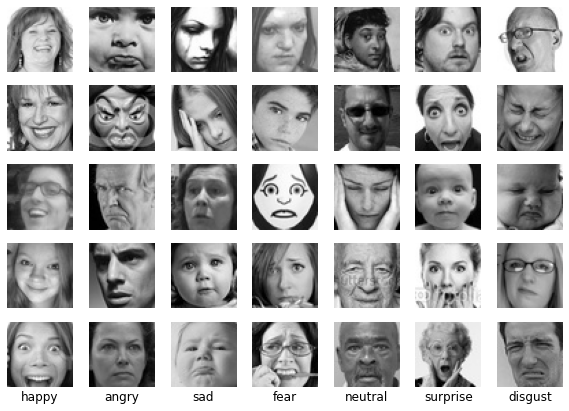

Testing samples:


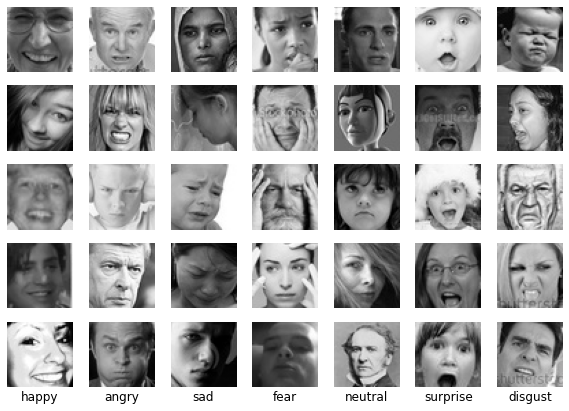

In [60]:
from keras.preprocessing.image import load_img

def show_samples(dir: Path):
    plt.figure(figsize=(10, 7))
    sample = 5
    for (i, emotion) in enumerate(dir.glob("*")):
        imgs = emotion.glob("*")
        for n in range(sample):
            img = load_img(emotion.joinpath(next(imgs).name))
            plt.subplot(sample, n_classes, i+1 + n_classes*n)
            plt.imshow(img)
            plt.axis('off')
        plt.title(emotion.name, y=-0.3)
            
    plt.show()

print('Training samples:')
show_samples(train_dir)
print('Testing samples:')
show_samples(test_dir)

We can quickly notice a few things. Firstly, the faces seem nicely centered though even if they weren't CNNs inherently are translate-invariant so it would not be a problem. Secondly, the training and testing set does not seem to differ substantially.

On the other hand, many issues can be identified:

1. Many of the pictures are stock pictures where the emotion is grossly exaggerated. This may cause the model to fail to learn the subtleties of how an emotion is expressed.
2. Different scales/rotations. Kernels in a CNN are not scale/rotation-invariant and will fail to generalize for different sizes/rotations of studied objects (lips, eyebrows, etc). Layers such as maxpooling are said to be helping here [[Deep Learning. Ian Goodfellow and Yoshua Bengio and Aaron Courville](https://www.deeplearningbook.org/)]
3. Different lightning conditions.
4. Mixture of real pictures with computer drawn. 
5. All previous arguments are technical limitations which can be overcome. However, one last important problem which can be noticed is that some of these emotion labels are very debatable. Me (as a fellow human) would fail to classify some of those to the associated label.

With all of that in mind, and our expectations being managed we proceed to prepare our model.

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


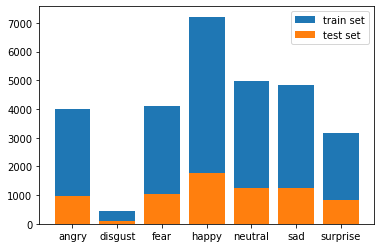

In [61]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

batch_size = 32

train_datagen = ImageDataGenerator(
    # normalize pixels to [0; 1]
    rescale=1/255,

    # will act as a regularizer
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True)
train = train_datagen.flow_from_directory(train_dir,
                                          batch_size=batch_size,
                                          target_size=image_size,
                                          shuffle=True,
                                          color_mode='grayscale',
                                          class_mode='categorical',
                                          seed=seed)

test_datagen = ImageDataGenerator(rescale=1/255)
test = test_datagen.flow_from_directory(test_dir,
                                        batch_size=batch_size,
                                        target_size=image_size,
                                        shuffle=True,
                                        color_mode='grayscale',
                                        class_mode='categorical',
                                        seed=seed)


def plot_dist(t_set: DirectoryIterator, legend: str) -> dict[str, int]:
    counts = {
        cl: np.count_nonzero(t_set.classes == i)
        for (cl, i) in t_set.class_indices.items()
    }
    plt.bar(counts.keys(), counts.values(), label=legend)
    plt.legend()

    return counts


dist1 = plot_dist(train, 'train set')
dist2 = plot_dist(test, 'test set')

The data is loaded straight from the directories using the keras helper function `flow_from_directory`. All images are normalized by rescaling pixels to the $[0; 1]$ range. We seed everything with our previously defined `seed` and prepare examples in batches. We also introduce a little bit of noise in the training examples: rotation, scaling, and horizontal flips. It will act as a simple regularizer.

In [62]:
def get_model():
        if load_saved_model:
                return keras.models.load_model(checkpoint_file)

        from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
        from keras import regularizers

        model = keras.models.Sequential()
        model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                activation='relu', input_shape=(*image_size, 1)))
        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
        model.add(BatchNormalization())
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(n_classes, activation='softmax'))

        model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=3e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )

        return model

model = get_model()
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 128)      

Now that the model is built, some callbacks will be added to monitor the training process. In this case only three will be added. One will save the best performing model and the other will reduce the learning rate if the training progress has stagnated (both with respect to the validation loss). Finally a simple logger will be added to be able to retroactively track the training process.

In [63]:
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_file,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min')


reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    verbose=1,
    patience=10)

logger = keras.callbacks.CSVLogger(log_file, append=load_saved_model)


callbacks = [checkpoint, reduce_lr, logger]

Finally, we train our model using the test set as training validation and with the previously defined callbacks.

In [64]:
_ = model.fit(x=train, validation_data=test, epochs=200, callbacks=callbacks)

Once done, we check basic measures such as accuracy and loss on both sets. As we can see, both sets have very comparable results, which tells us no overfitting occurred during training.

In [65]:
_ = model.evaluate(train)
_ = model.evaluate(test)

225/225 [==============================] - 11s 50ms/step - loss: 1.8636 - accuracy: 0.5422
